In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split

In [2]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# Animal Welfare Center dataset

In [3]:
original_data = pd.read_csv("kaggle_files/animal_welfare_center.csv")

In [4]:
data = original_data.copy()

In [5]:
data.head()

,animal_id_outcome,dob_year,dob_month,age_upon_intake,animal_type,breed,color,intake_condition,intake_type,sex_upon_intake,count,age_upon_intake_(days),age_upon_intake_(years),age_upon_intake_age_group,intake_datetime,intake_month,intake_year,intake_monthyear,intake_weekday,intake_hour,intake_number,time_in_shelter,time_in_shelter_days,age_upon_outcome,date_of_birth,sex_upon_outcome,age_upon_outcome_(days),age_upon_outcome_(years),age_upon_outcome_age_group,outcome_datetime,outcome_month,outcome_year,outcome_monthyear,outcome_weekday,outcome_hour,outcome_number,outcome_type
0,A006100,2007,7,10 years,Dog,Spinone Italiano Mix,Yellow/White,Normal,Stray,Neutered Male,1,3650,10.0,"(7.5, 10.0]",2017-12-07 00:00:00,12,2017,2017-12,Thursday,14,1.0,0 days 14:07:00.000000000,0.588194,10 years,2007-07-09 00:00:00,Neutered Male,3650,10.0,"(7.5, 10.0]",2017-12-07 14:07:00,12,2017,2017-12,Thursday,0,1.0,Return to Owner
1,A006100,2007,7,7 years,Dog,Spinone Italiano Mix,Yellow/White,Normal,Public Assist,Neutered Male,1,2555,7.0,"(5.0, 7.5]",2014-12-19 10:21:00,12,2014,2014-12,Friday,10,2.0,1 days 06:14:00.000000000,1.259722,7 years,2007-07-09 00:00:00,Neutered Male,2555,7.0,"(5.0, 7.5]",2014-12-20 16:35:00,12,2014,2014-12,Saturday,16,2.0,Return to Owner
2,A006100,2007,7,6 years,Dog,Spinone Italiano Mix,Yellow/White,Normal,Public Assist,Neutered Male,1,2190,6.0,"(5.0, 7.5]",2014-03-07 14:26:00,3,2014,2014-03,Friday,14,3.0,1 days 02:44:00.000000000,1.113889,6 years,2007-07-09 00:00:00,Neutered Male,2190,6.0,"(5.0, 7.5]",NaN,3,2014,2014-03,Saturday,17,3.0,Return to Owner
3,A047759,2004,4,10 years,Dog,Dachshund,Tricolor,Normal,Owner Surrender,Neutered Male,1,3650,10.0,"(7.5, 10.0]",2014-04-02 15:55:00,4,2014,2014-04,Wednesday,15,1.0,4 days 23:17:00.000000000,4.970139,10 years,2004-04-02 00:00:00,Neutered Male,3650,10.0,"(7.5, 10.0]",2014-04-07 15:12:00,4,2014,2014-04,Monday,15,1.0,Missing
4,A134067,1997,10,16 years,Dog,Shetland Sheepdog,Brown/White,Injured,Public Assist,Neutered Male,1,5840,16.0,"(15.0, 17.5]",2013-11-16 09:02:00,11,2013,2013-11,Saturday,9,1.0,0 days 02:52:00.000000000,0.119444,16 years,1997-10-16 00:00:00,Neutered Male,5840,16.0,"(15.0, 17.5]",2013-11-16 11:54:00,11,2013,2013-11,Saturday,11,1.0,Return to Owner


In [6]:
data.outcome_type.value_counts()

Adoption           12967
Transfer           10345
Return to Owner     9718
Euthanasia          4144
Died                2829
Missing             2599
Relocate            2573
Rto-Adopt           2450
Disposal             178
Name: outcome_type, dtype: int64

#### We will focus only on the animals that got adopted, trying to predict a model for adoption,

In [7]:
data = data[data['outcome_type'].isin(["Adoption", "Rto-Adopt", "Return to Owner"])]

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25135 entries, 0 to 47801
Data columns (total 37 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   animal_id_outcome           25135 non-null  object 
 1   dob_year                    25135 non-null  int64  
 2   dob_month                   25135 non-null  int64  
 3   age_upon_intake             25135 non-null  object 
 4   animal_type                 25135 non-null  object 
 5   breed                       25135 non-null  object 
 6   color                       25135 non-null  object 
 7   intake_condition            25135 non-null  object 
 8   intake_type                 25135 non-null  object 
 9   sex_upon_intake             25134 non-null  object 
 10  count                       25135 non-null  int64  
 11  age_upon_intake_(days)      25135 non-null  int64  
 12  age_upon_intake_(years)     25135 non-null  float64
 13  age_upon_intake_age_group   251

## Data Cleaning

In [9]:
# List of columns that have unnecessary/redundant information
drop_columns = ["age_upon_intake", "count", "age_upon_intake_(days)", "intake_datetime", "time_in_shelter",
                "intake_monthyear" , "age_upon_outcome", "date_of_birth", "age_upon_outcome_(days)",
                "sex_upon_outcome", "age_upon_intake_age_group", "age_upon_outcome_age_group",
                "outcome_datetime", "outcome_monthyear", "outcome_number", "intake_hour", "outcome_hour"]

In [10]:
# select numerical features for correlations
numerical = data.select_dtypes(np.number)

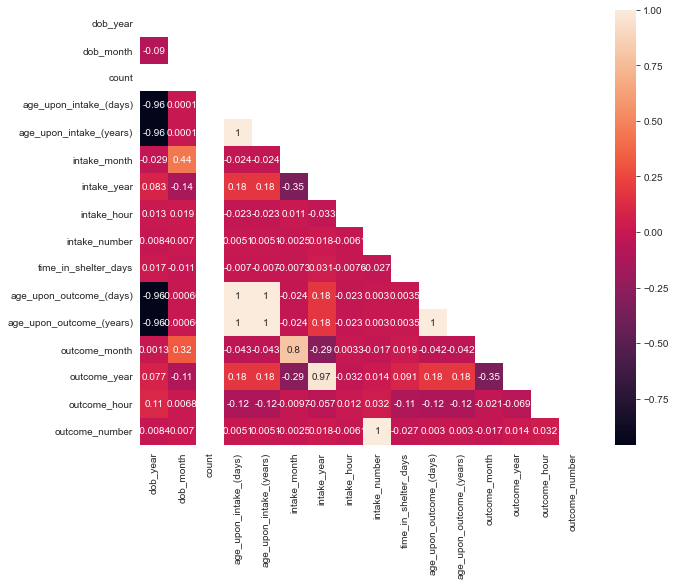

In [11]:
correlations = numerical.corr() # create the correlations

mask = np.zeros_like(correlations) # create an array with size of correlations

mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(correlations, mask=mask, annot=True)
plt.show()

#### Outcome and income values are almost the same because the duration that animals spent at the center are short, therefore high correlations. More columns need to be dropped.

In [12]:
# Dropping more columns after reducing the data
drop_columns.extend(["dob_year", "age_upon_outcome_(days)", "age_upon_outcome_(years)", "outcome_year"]) # use extend([]) instead of multiple append()

In [13]:
len(data.animal_id_outcome.unique())/len(data)

0.877501491943505

#### The data has multiple entries for the same animal. About 89% of our data are unique animals. Enough data will remain after removing the duplicate intakes. The duplicates will be dropped.

In [14]:
# Remove duplicate rows for same animal
data = data[data['intake_number']== 1]

In [15]:
# now useless columns
drop_columns.extend(["animal_id_outcome", "intake_number"]) # use extend([]) instead of multiple append()

data = data.drop(columns=drop_columns)                      # dropping unnecessary columns

In [16]:
# Change column names for better understanding
data.rename(columns={'age_upon_intake':'age(years)',
                        "sex_upon_intake" : "sex"}, inplace=True)

In [17]:
# Exploring the values in our data to look for values that are unclear
for i in data.columns:
        print("------------------------")
        x = data[i].value_counts()
        print(x)

------------------------
4     2206
3     1991
5     1878
10    1782
6     1715
8     1682
9     1676
1     1675
12    1669
7     1634
2     1559
11    1517
Name: dob_month, dtype: int64
------------------------
Dog      14705
Cat       6147
Other       74
Bird        58
Name: animal_type, dtype: int64
------------------------
Domestic Shorthair Mix                             4683
Pit Bull Mix                                       1704
Chihuahua Shorthair Mix                            1578
Labrador Retriever Mix                             1302
German Shepherd Mix                                 580
                                                   ... 
American Staffordshire Terrier/American Bulldog       1
Jack Russell Terrier/Miniature Schnauzer              1
Boxer/Cardigan Welsh Corgi                            1
Pembroke Welsh Corgi/Pit Bull                         1
Mastiff/Bloodhound                                    1
Name: breed, Length: 1426, dtype: int64
---------------

In [18]:
# What animals have these Unknown values
# no_sex = data[data["sex"]=="Unknown"]
# no_sex.animal_type.value_counts()

In [19]:
no_age = data[data["age_upon_intake_(years)"]==0]                              # select data where age is 0
# print(no_age[no_age.dob_month - no_age.intake_month])
no_age_list= list(no_age[(no_age.dob_month - no_age.intake_month ) >0 ].index) # get list of those indices 
data.loc[no_age_list, "dob_month"] = data["dob_month"] - 1                     # reduce dob_month by 1 to match intake_month

#### The zeros in the "age_upon_intake_(years)" are not missing values, they indicate a very young (or new born) animal at the Center. Some wrong values were cleaned.

In [20]:
data["sex"] = data['sex'].replace('Unknown', np.NaN)  # Replacing "Unknown" strings with Nans

In [21]:
data.sex.value_counts(dropna =False)/len(data) # How much of the data are NaNs now?

Intact Male      0.304422
Intact Female    0.271350
Neutered Male    0.220072
Spayed Female    0.196102
NaN              0.008054
Name: sex, dtype: float64

#### With around 9% of our data being NaNs we will not drop them, instead we will fill the missing values randomly with values from that column.

In [22]:
def random_nans(df, col):                                   # take the dataframe and the specified column
    print("NaNs before:", df[col].isna().sum())             # sanity check for NaNs before removing
    
    x = df.copy()                                           # copy dataframe for mask
    mask = df[col].isna()                                   # create the mask correlating to NaNs
    sexes = df[col].dropna().unique()                       # get unique entries in specified column
    
    x.loc[mask, col] = random.choices(sexes, k=mask.sum())    # apply mask to copied dataframe and replace NaNs 
                                                                                 # with random entries from the list
    print("NaNs after:" , x[col].isna().sum())              # sanity check for NaNs after removing
    return x

In [23]:
data = random_nans(data, "sex")

NaNs before: 169
NaNs after: 0


In [24]:
def group_by_value(data,col,num,rename):                         # take 4 arguments: dataframe, column to modify,
                                                                 # cut of number and string u want to rename the NaNs to
    data2 = data.copy()
    
    breed1 = pd.DataFrame([data2[col].value_counts()<num]).T     # select dataframe where column has values less than specified
    mask1 = breed1.loc[breed1[col]==True].index                  # create mask with index of selected data
    df1 = data2[data2[col].isin(mask1)]                          # create dataframe with mask
    df1[col] = rename                                            # rename all entries in column

    #similar to code above, this time with values >= to specified number
    breed2 = pd.DataFrame([data2[col].value_counts()>=num]).T
    mask2 = breed2.loc[breed2[col]==True].index
    df2 = data2[data2[col].isin(mask2)]

    df = pd.concat([df1,df2] , axis = 0)                          # Combine modified dataframe with unmodified 
    
    print("The", col, "column now has", len(df[col].value_counts()), "unique entries")
    return df

In [25]:
data = group_by_value(data, "breed", 100, "Other")
data = group_by_value(data,"color", 120, "Other")

The breed column now has 26 unique entries
The color column now has 39 unique entries


In [26]:
data = data.reset_index(drop=True)

## Data Exploration

In [27]:
iqr = np.percentile(data["time_in_shelter_days"], 75) - np.percentile(data["time_in_shelter_days"], 25)
upper_limit = np.percentile(data["time_in_shelter_days"], 75) + 1.5 * iqr
lower_limit = np.percentile(data["time_in_shelter_days"], 25) - 1.5 * iqr

mask_outlier = (data.time_in_shelter_days > upper_limit) | (data.time_in_shelter_days < lower_limit) # condition of being an outlier
mask_not_outlier = ( data.time_in_shelter_days <= upper_limit) & (data.time_in_shelter_days >= lower_limit) # condition of not not being outlier 
outliers_time_in_shelter_days = data[mask_outlier] # here it is the dataset with the outliers of time_in_shelter_days
cleaned_outliers_time_in_shelter_days = data[mask_not_outlier ] # here we have the dataset without outliers of time_in_shelter_days
#display(cleaned_outliers)
data_no_outl = data[(data.time_in_shelter_days < upper_limit) & (data.time_in_shelter_days > lower_limit)]
print("Shape of dataset with outliers:", data.shape)
print("Shape of dataset without outliers:", data_no_outl.shape)

Shape of dataset with outliers: (20984, 15)
Shape of dataset without outliers: (18070, 15)


<AxesSubplot:ylabel='Density'>

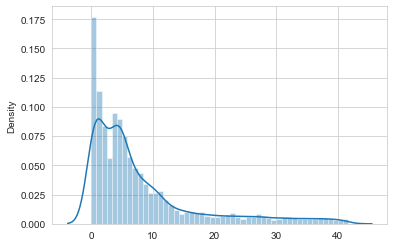

In [28]:
# VISUALIZE VARIABLES VS TARGET
y = data_no_outl.time_in_shelter_days
sns.distplot(x=y)

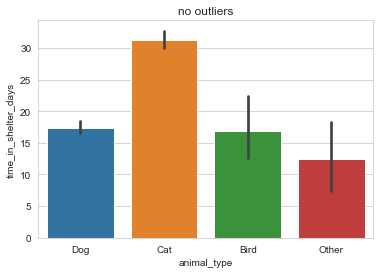

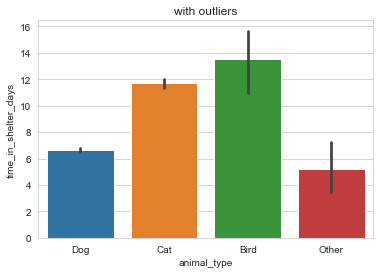

In [29]:
sns.barplot(x="animal_type", y="time_in_shelter_days", data=data) # mean of the 3 categories
plt.title("no outliers")
plt.show()
sns.barplot(x="animal_type", y="time_in_shelter_days", data=data_no_outl) # mean of the 3 categories
plt.title("with outliers")
plt.show()

In [30]:
# average time in shelter by type
print("with outliers:" ,data[["animal_type", "time_in_shelter_days"]].groupby("animal_type")["time_in_shelter_days"].mean())
print("-------------")
print("no outliers:" ,data_no_outl[["animal_type", "time_in_shelter_days"]].groupby("animal_type")["time_in_shelter_days"].mean()) 

with outliers: animal_type
Bird     16.903257
Cat      31.245074
Dog      17.408520
Other    12.408164
Name: time_in_shelter_days, dtype: float64
-------------
no outliers: animal_type
Bird     13.550227
Cat      11.691861
Dog       6.659396
Other     5.187687
Name: time_in_shelter_days, dtype: float64


# What can we see here?

In [31]:
#sns.scatterplot(x="breed", y="time_in_shelter_days", data=data) 

In [32]:
#fig, ax = plt.subplots(1,1)
#sns.histplot(x="time_in_shelter_days", hue= "color", data=data, bins=400)
#ax.set_xlim((0,50))
#plt.show()

In [33]:
#sns.boxplot(cleaned_outliers_time_in_shelter_days["time_in_shelter_days"])

In [34]:
#sns.pairplot(data)

# Feature Engineering

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20984 entries, 0 to 20983
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   dob_month                20984 non-null  int64  
 1   animal_type              20984 non-null  object 
 2   breed                    20984 non-null  object 
 3   color                    20984 non-null  object 
 4   intake_condition         20984 non-null  object 
 5   intake_type              20984 non-null  object 
 6   sex                      20984 non-null  object 
 7   age_upon_intake_(years)  20984 non-null  float64
 8   intake_month             20984 non-null  int64  
 9   intake_year              20984 non-null  int64  
 10  intake_weekday           20984 non-null  object 
 11  time_in_shelter_days     20984 non-null  float64
 12  outcome_month            20984 non-null  int64  
 13  outcome_weekday          20984 non-null  object 
 14  outcome_type          

In [36]:
data = data.drop(columns=["outcome_month", "outcome_weekday"])  # not useful for regression
data_no_outl = data_no_outl.drop(columns=["outcome_month", "outcome_weekday"])  # not useful for regression

# Outlier Analysis

In [37]:
feature = "time_in_shelter_days"    # target feature                

In [38]:
# Function to scale categorical data, either with frequency encoding or dummification
def encoding(data, fe):                                          # dataset, option to use frequency encoding
    numerical = data.select_dtypes(np.number)                                         # numerical data
    categorical = data.select_dtypes(object)                                          # categorical data
    if fe:                                                                            # enable frequency encoding?
        for col in categorical.columns:
            col_enc = (data.groupby(col).size()) / len(data)                          # get relative size for each value
            categorical[col] = categorical[col].apply(lambda x : col_enc[x])          # replace values with their relative value
        categorical.columns = [str(col) + '_encode' for col in categorical.columns]   # rename columns after encoding
    else: 
        categorical = pd.get_dummies(categorical, drop_first = True)                  # if frequency encoding was not enabled
                                                                                      # dummification of features will be used
        
    data = pd.concat([numerical, categorical] , axis = 1)           # concatenate both numerical and categorical dataframes
    return data                                                     # return data

In [39]:
def model_inplace(data, feature, scaler, model):
    X = data[data.columns.drop(feature)]  # features for regression
    y = data[feature]                     # target feature         
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 42)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    model.fit(X_train,y_train)
    print(scaler, model)
    print("train:", model.score(X_train, y_train))
    print("test:", model.score(X_test, y_test))
    try:
        feature_importance = pd.DataFrame({ 
        "feature_names": X.columns,
        "coefficients": abs(model.coef_)
        })
        feature_importance = feature_importance.sort_values(["coefficients"], ascending=False) # Ranking the features
    except:
        print("NO FEATURES AVAILABLE")
        return 0
    return feature_importance

In [40]:
# different scaler
stdscal = StandardScaler()
minmax = MinMaxScaler()
scaler_list = [stdscal, minmax]

#different Regresser
lreg = LinearRegression()
ridge = Ridge(alpha = 100)
lasso = Lasso(alpha = 0)
reg_list = [lreg, ridge, lasso]

In [41]:
fe = False
data_enc = encoding(data, fe)
data_no_outl_enc = encoding(data_no_outl, fe)
data_list = [data_enc, data_no_outl_enc]

In [42]:
for encoded in data_list:
    print("NEW DATA")
    for scaler in scaler_list:
        print("")
        for reg in reg_list:
            feature_importance = model_inplace(encoded, feature, scaler, reg)
            print("")
            display(feature_importance)
    print("------------------------------------")  

NEW DATA

StandardScaler() LinearRegression()
train: 0.09490772092808408
test: 0.07591710608245406



,feature_names,coefficients
90,outcome_type_Return to Owner,15.832120
24,breed_Other,11.507127
14,breed_Chihuahua Shorthair Mix,7.419045
18,breed_Domestic Shorthair Mix,7.176585
4,animal_type_Cat,6.199229
...,...,...
87,intake_weekday_Thursday,0.064226
67,color_White/Brown,0.037467
43,color_Brown Tabby/White,0.029608
57,color_Red/White,0.024664


StandardScaler() Ridge(alpha=100)
train: 0.09466863222125421
test: 0.0745988366284549



,feature_names,coefficients
90,outcome_type_Return to Owner,15.607001
24,breed_Other,6.304321
1,age_upon_intake_(years),5.472756
76,intake_condition_Sick,4.598524
14,breed_Chihuahua Shorthair Mix,4.511499
...,...,...
49,color_Chocolate/White,0.068281
87,intake_weekday_Thursday,0.059651
67,color_White/Brown,0.057231
41,color_Brown Brindle/White,0.040496


StandardScaler() Lasso(alpha=0)
train: 0.09490771279602406
test: 0.07591417457256111



,feature_names,coefficients
90,outcome_type_Return to Owner,15.832175
24,breed_Other,11.506920
14,breed_Chihuahua Shorthair Mix,7.418883
18,breed_Domestic Shorthair Mix,7.176434
4,animal_type_Cat,6.199459
...,...,...
87,intake_weekday_Thursday,0.064186
67,color_White/Brown,0.037429
43,color_Brown Tabby/White,0.029599
57,color_Red/White,0.024629



MinMaxScaler() LinearRegression()
train: 0.09490772092808408
test: 0.07591710608245428



,feature_names,coefficients
76,intake_condition_Sick,40.487352
73,intake_condition_Nursing,39.418893
1,age_upon_intake_(years),37.761845
90,outcome_type_Return to Owner,32.944906
23,breed_Miniature Schnauzer Mix,32.849719
...,...,...
67,color_White/Brown,0.237425
49,color_Chocolate/White,0.213019
57,color_Red/White,0.200113
43,color_Brown Tabby/White,0.190902


MinMaxScaler() Ridge(alpha=100)
train: 0.09113397284564584
test: 0.0723762751820558



,feature_names,coefficients
90,outcome_type_Return to Owner,30.487911
1,age_upon_intake_(years),24.145799
25,breed_Pit Bull Mix,16.604567
76,intake_condition_Sick,12.694147
73,intake_condition_Nursing,10.789906
...,...,...
75,intake_condition_Pregnant,0.388653
21,breed_Labrador Retriever Mix,0.386717
42,color_Brown Tabby,0.310990
87,intake_weekday_Thursday,0.180311


MinMaxScaler() Lasso(alpha=0)
train: 0.09490771279602406
test: 0.07591417457256122



,feature_names,coefficients
76,intake_condition_Sick,40.491878
73,intake_condition_Nursing,39.419065
1,age_upon_intake_(years),37.761788
90,outcome_type_Return to Owner,32.945021
23,breed_Miniature Schnauzer Mix,32.849317
...,...,...
67,color_White/Brown,0.237182
49,color_Chocolate/White,0.213154
57,color_Red/White,0.199829
43,color_Brown Tabby/White,0.190849


------------------------------------
NEW DATA

StandardScaler() LinearRegression()
train: 0.26065146141224904
test: 0.24464860643456043



,feature_names,coefficients
90,outcome_type_Return to Owner,4.614738
79,intake_type_Stray,2.855673
77,intake_type_Owner Surrender,2.740062
24,breed_Other,1.526951
5,animal_type_Dog,1.063781
...,...,...
37,color_Blue Tabby/White,0.040240
30,breed_Staffordshire Mix,0.028433
75,intake_condition_Pregnant,0.025073
49,color_Chocolate/White,0.021992


StandardScaler() Ridge(alpha=100)
train: 0.26034733667531096
test: 0.24481540591632445



,feature_names,coefficients
90,outcome_type_Return to Owner,4.550854
91,outcome_type_Rto-Adopt,1.042781
78,intake_type_Public Assist,0.969152
77,intake_type_Owner Surrender,0.855464
5,animal_type_Dog,0.843969
...,...,...
75,intake_condition_Pregnant,0.020844
49,color_Chocolate/White,0.009040
8,breed_Australian Shepherd Mix,0.006267
70,intake_condition_Feral,0.006184


StandardScaler() Lasso(alpha=0)
train: 0.2606486200524871
test: 0.24473365277926373



,feature_names,coefficients
90,outcome_type_Return to Owner,4.614596
79,intake_type_Stray,2.535443
77,intake_type_Owner Surrender,2.467075
24,breed_Other,1.526818
5,animal_type_Dog,1.063951
...,...,...
37,color_Blue Tabby/White,0.040261
30,breed_Staffordshire Mix,0.028458
75,intake_condition_Pregnant,0.025082
49,color_Chocolate/White,0.021922



MinMaxScaler() LinearRegression()
train: 0.26065146141224904
test: 0.24464860643456043



,feature_names,coefficients
80,intake_type_Wildlife,13.842216
90,outcome_type_Return to Owner,9.371361
77,intake_type_Owner Surrender,7.115157
79,intake_type_Stray,6.310484
28,breed_Siamese Mix,5.708828
...,...,...
85,intake_weekday_Saturday,0.324287
81,sex_Intact Male,0.251809
49,color_Chocolate/White,0.214908
84,intake_weekday_Monday,0.197362


MinMaxScaler() Ridge(alpha=100)
train: 0.25674045889976727
test: 0.24449178173685682



,feature_names,coefficients
90,outcome_type_Return to Owner,8.742852
91,outcome_type_Rto-Adopt,3.068494
78,intake_type_Public Assist,3.064491
1,age_upon_intake_(years),1.860993
77,intake_type_Owner Surrender,1.860689
...,...,...
70,intake_condition_Feral,0.038353
63,color_Tortie,0.031067
35,color_Blue,0.028782
56,color_Red,0.024194


MinMaxScaler() Lasso(alpha=0)
train: 0.2606486200524871
test: 0.24473365277926362



,feature_names,coefficients
80,intake_type_Wildlife,13.138472
90,outcome_type_Return to Owner,9.371074
77,intake_type_Owner Surrender,6.406289
28,breed_Siamese Mix,5.710364
79,intake_type_Stray,5.602837
...,...,...
85,intake_weekday_Saturday,0.323615
81,sex_Intact Male,0.251874
49,color_Chocolate/White,0.214229
84,intake_weekday_Monday,0.197002


------------------------------------


#### Score on Data without outliers is about 0.05 r2-score better.

In [43]:
data = data.drop(columns=["intake_month", "intake_year", "intake_weekday", "dob_month"])  # not useful for regression
data_no_outl = data_no_outl.drop(columns=["intake_month", "intake_year", "intake_weekday", "dob_month"])  # not useful for regression

In [44]:
fe = False
data_enc = encoding(data, fe)
data_no_outl_enc = encoding(data_no_outl, fe)
data_list = [data_enc, data_no_outl_enc]

In [45]:
for encoded in data_list:
    print("NEW DATA")
    for scaler in scaler_list:
        print("")
        for reg in reg_list:
            feature_importance = model_inplace(encoded, feature, scaler, reg)
            print("")
            display(feature_importance)
    print("------------------------------------")  

NEW DATA

StandardScaler() LinearRegression()
train: 0.09338881756167094
test: 0.07401604478484203



,feature_names,coefficients
81,outcome_type_Return to Owner,15.787386
21,breed_Other,11.634595
11,breed_Chihuahua Shorthair Mix,7.469891
15,breed_Domestic Shorthair Mix,7.148895
0,age_upon_intake_(years),5.865265
...,...,...
38,color_Brown Brindle/White,0.105079
40,color_Brown Tabby/White,0.064558
64,color_White/Brown,0.058417
54,color_Red/White,0.035830


StandardScaler() Ridge(alpha=100)
train: 0.09315904020073595
test: 0.07275639272786005



,feature_names,coefficients
81,outcome_type_Return to Owner,15.565074
21,breed_Other,6.396676
0,age_upon_intake_(years),5.744463
73,intake_condition_Sick,4.560982
11,breed_Chihuahua Shorthair Mix,4.544284
...,...,...
27,breed_Staffordshire Mix,0.095267
46,color_Chocolate/White,0.079261
64,color_White/Brown,0.036516
38,color_Brown Brindle/White,0.033959


StandardScaler() Lasso(alpha=0)
train: 0.09338881443366298
test: 0.0740141810789281



,feature_names,coefficients
81,outcome_type_Return to Owner,15.787421
21,breed_Other,11.634389
11,breed_Chihuahua Shorthair Mix,7.469748
15,breed_Domestic Shorthair Mix,7.148727
0,age_upon_intake_(years),5.865253
...,...,...
38,color_Brown Brindle/White,0.105011
40,color_Brown Tabby/White,0.064551
64,color_White/Brown,0.058394
54,color_Red/White,0.035808



MinMaxScaler() LinearRegression()
train: 0.09338881756167094
test: 0.07401604478484203



,feature_names,coefficients
73,intake_condition_Sick,40.210736
70,intake_condition_Nursing,39.664801
0,age_upon_intake_(years),39.636165
20,breed_Miniature Schnauzer Mix,33.020074
7,breed_Border Collie Mix,32.939151
...,...,...
38,color_Brown Brindle/White,0.748105
40,color_Brown Tabby/White,0.416252
64,color_White/Brown,0.370187
46,color_Chocolate/White,0.318754


MinMaxScaler() Ridge(alpha=100)
train: 0.08954596386498193
test: 0.07058589409070948



,feature_names,coefficients
81,outcome_type_Return to Owner,30.371923
0,age_upon_intake_(years),25.401571
22,breed_Pit Bull Mix,16.864247
73,intake_condition_Sick,12.522823
70,intake_condition_Nursing,10.975610
...,...,...
2,animal_type_Dog,0.392125
72,intake_condition_Pregnant,0.382186
18,breed_Labrador Retriever Mix,0.340973
36,color_Brown,0.247215


MinMaxScaler() Lasso(alpha=0)
train: 0.09338881443366309
test: 0.0740141810789281



,feature_names,coefficients
73,intake_condition_Sick,40.213556
70,intake_condition_Nursing,39.664910
0,age_upon_intake_(years),39.636081
20,breed_Miniature Schnauzer Mix,33.019661
7,breed_Border Collie Mix,32.938713
...,...,...
38,color_Brown Brindle/White,0.747617
40,color_Brown Tabby/White,0.416210
64,color_White/Brown,0.370040
46,color_Chocolate/White,0.318836


------------------------------------
NEW DATA

StandardScaler() LinearRegression()
train: 0.25786876860693664
test: 0.245355033793748



,feature_names,coefficients
81,outcome_type_Return to Owner,4.618665
76,intake_type_Stray,2.951952
74,intake_type_Owner Surrender,2.825897
21,breed_Other,1.527251
82,outcome_type_Rto-Adopt,1.054485
...,...,...
34,color_Blue Tabby/White,0.043662
72,intake_condition_Pregnant,0.029258
27,breed_Staffordshire Mix,0.027010
46,color_Chocolate/White,0.025440


StandardScaler() Ridge(alpha=100)
train: 0.2575561015540805
test: 0.24545730617259431



,feature_names,coefficients
81,outcome_type_Return to Owner,4.554482
82,outcome_type_Rto-Adopt,1.036708
75,intake_type_Public Assist,0.959234
74,intake_type_Owner Surrender,0.868651
2,animal_type_Dog,0.802383
...,...,...
72,intake_condition_Pregnant,0.024896
46,color_Chocolate/White,0.012425
5,breed_Australian Shepherd Mix,0.002895
8,breed_Boxer Mix,0.002500


StandardScaler() Lasso(alpha=0)
train: 0.25786572580919365
test: 0.24544364586403367



,feature_names,coefficients
81,outcome_type_Return to Owner,4.618522
76,intake_type_Stray,2.620688
74,intake_type_Owner Surrender,2.543506
21,breed_Other,1.527060
82,outcome_type_Rto-Adopt,1.054612
...,...,...
34,color_Blue Tabby/White,0.043686
72,intake_condition_Pregnant,0.029264
27,breed_Staffordshire Mix,0.027038
46,color_Chocolate/White,0.025370



MinMaxScaler() LinearRegression()
train: 0.25786876860693664
test: 0.245355033793748



,feature_names,coefficients
77,intake_type_Wildlife,14.158367
81,outcome_type_Return to Owner,9.379337
74,intake_type_Owner Surrender,7.338047
76,intake_type_Stray,6.523241
25,breed_Siamese Mix,5.696728
...,...,...
27,breed_Staffordshire Mix,0.406844
67,intake_condition_Feral,0.324614
78,sex_Intact Male,0.252917
46,color_Chocolate/White,0.248603


MinMaxScaler() Ridge(alpha=100)
train: 0.25399182755651883
test: 0.24478933313019802



,feature_names,coefficients
81,outcome_type_Return to Owner,8.753467
75,intake_type_Public Assist,3.060616
82,outcome_type_Rto-Adopt,3.054457
74,intake_type_Owner Surrender,1.868095
0,age_upon_intake_(years),1.748495
...,...,...
38,color_Brown Brindle/White,0.044923
56,color_Tan,0.035634
53,color_Red,0.027113
72,intake_condition_Pregnant,0.009348


MinMaxScaler() Lasso(alpha=0)
train: 0.25786572580919376
test: 0.24544364586403367



,feature_names,coefficients
77,intake_type_Wildlife,13.429992
81,outcome_type_Return to Owner,9.379046
74,intake_type_Owner Surrender,6.604759
76,intake_type_Stray,5.791212
25,breed_Siamese Mix,5.698306
...,...,...
27,breed_Staffordshire Mix,0.407255
67,intake_condition_Feral,0.323820
78,sex_Intact Male,0.252980
46,color_Chocolate/White,0.247917


------------------------------------


In [46]:
from sklearn.model_selection import GridSearchCV

# first selection method 


# learn is what is the best alhpa on Lasso
params = {"alpha":  np.arange(0,1000,100)}
grid = GridSearchCV(lasso,  param_grid= params, cv=10, verbose=1)

X = data_enc[data_enc.columns.drop(feature)]  # features for regression
y = data_enc[feature]                         # target feature         
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 42)

X_train = stdscal.fit_transform(X_train)
X_test = stdscal.transform(X_test)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_
print("coefficients model", best_model.coef_)
print("score on train set:", best_model.score(X_train, y_train))
print("score on test set:", best_model.score(X_test, y_test))

# feature selection is taking features that are irrelevant for the model
print("columns that were removed by Lasso", X.columns[best_model.coef_ ==0])
print("columns that were NOT removed by Lasso", X.columns[best_model.coef_ !=0])
print("best alpha", grid.best_params_)

# 0, 10/1000, 20/1000, ....
# np.arange(0,10,1): 0, 0.1, 0.2, 0.3, 04, 0.5,...,1 --> dividing the interval [0,1] in 10 pieces


Fitting 10 folds for each of 10 candidates, totalling 100 fits
coefficients model [  5.86525251   5.07672243   3.83332039   0.42653807  -2.54194843
  -2.83615358  -2.08483065  -3.27861652  -2.11841188  -1.04555216
  -2.29756492  -7.46974757  -3.46383356  -3.05905943  -2.3837059
  -7.14872722  -3.90195084  -2.58293902  -5.7160903   -3.28991518
  -2.84993741 -11.63438901  -1.16687627  -2.62404683  -1.00801391
  -3.03457891  -2.31902445  -0.65717251  -2.6765043   -0.76429509
  -0.93213429  -0.40764778  -1.24165079  -0.55638719   0.10686165
  -0.27672924  -0.45399448  -0.80311151  -0.10501084  -0.69538948
   0.06455109  -0.65260696  -0.61480067  -0.89581356  -0.76079986
  -0.39093467   0.0322918   -0.49271797  -1.06574595   0.17456463
  -0.71292551  -0.95972769  -2.0747932   -0.58309726  -0.03580794
  -0.77846737  -1.2699658   -0.77272917  -0.32984354  -0.61318798
  -0.50263206  -1.19294043  -1.63734192  -1.08990902  -0.05839421
   0.17123547  -0.91757905   0.37112356   5.00933062   3.1774

In [47]:
# learn is what is the best alhpa on ridge
params = {"alpha":  np.arange(0,1000,100)}
grid = GridSearchCV(ridge,  param_grid= params, cv=10, verbose=1)

X = data_enc[data_enc.columns.drop(feature)]  # features for regression
y = data_enc[feature]                         # target feature         
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 42)

X_train = stdscal.fit_transform(X_train)
X_test = stdscal.transform(X_test)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_
print("coefficients model", best_model.coef_)
print("score on train set:", best_model.score(X_train, y_train))
print("score on test set:", best_model.score(X_test, y_test))

# feature selection is taking features that are irrelevant for the model
print("columns that were removed by Lasso", X.columns[best_model.coef_ ==0])
print("columns that were NOT removed by Lasso", X.columns[best_model.coef_ !=0])
print("best alpha", grid.best_params_)

# 0, 10/1000, 20/1000, ....
# np.arange(0,10,1): 0, 0.1, 0.2, 0.3, 04, 0.5,...,1 --> dividing the interval [0,1] in 10 pieces


Fitting 10 folds for each of 10 candidates, totalling 100 fits
coefficients model [ 5.74446340e+00  2.62792705e+00  1.71387132e+00  1.40205767e-01
 -1.10301636e+00 -1.79875985e+00 -1.26700134e+00 -2.17385330e+00
 -9.94415793e-01 -1.26061901e-01 -1.50167276e+00 -4.54428388e+00
 -2.17373982e+00 -1.51909211e+00 -6.45139659e-01 -2.21926063e+00
 -2.08463931e+00 -1.68974546e+00 -3.01659152e+00 -2.08212938e+00
 -1.88903244e+00 -6.39667607e+00  1.81030713e+00 -1.73295850e+00
 -1.98457747e-01 -1.75636805e+00 -1.40040309e+00  9.52674173e-02
 -1.72205180e+00 -7.22848801e-01 -8.80185927e-01 -3.01950202e-01
 -1.18438463e+00 -5.20087822e-01  1.29515620e-01 -2.12923403e-01
 -4.09678061e-01 -7.62961934e-01 -3.39590884e-02 -6.25696163e-01
  1.15633272e-01 -6.15431032e-01 -5.40170352e-01 -8.65545341e-01
 -7.18515529e-01 -3.66543483e-01  7.92614824e-02 -4.70844324e-01
 -1.03051727e+00  2.05485274e-01 -6.63973510e-01 -9.17346030e-01
 -1.93344154e+00 -5.53070255e-01  4.67484138e-03 -7.46700355e-01
 -1.2222

### Extracting data for visualization

In [48]:
data.to_excel("Animal_Welfare_Center.xlsx", index = False)